# Evaluate Extraction Methods

This notebook goes over the process of evaluating the bit error rate for a recorded batch of traces for SpectrEM. In our paper, we chose a batch size of 81920 traces.

In [8]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy as sp
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'   # Disable tensorflow logs
import tensorflow as tf

from matplotlib import pyplot as plt
from scipy.fft import fft
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

## Evaluate traces

We now walk through evaluating a batch of traces.

We first load in the traces. If you do not have access to an EM measurement setup, you can find our pre-recorded traces in an archived [repository](https://rdr.kuleuven.be/dataset.xhtml?persistentId=doi:10.48804/AHTI1A).

In [ ]:
# Path to the directory that contains the pre-recorded traces.
prerecorded_traces_dir = "../../traces"

In [121]:
filename_cf = f"{prerecorded_traces_dir}/0-base-experiments/spectrem/cf/setup-b/spectrem_cf_0000.hdf5"
filename_ins = f"{prerecorded_traces_dir}/0-base-experiments/spectrem/ins/setup-b/spectrem_ins_0000.hdf5"

f_cf = h5py.File(filename_cf, "r", libver="latest")
f_ins = h5py.File(filename_ins, "r", libver="latest")

traces_cf = f_cf["data"]["traces"]
inputs_cf = f_cf["data"]["inputs"]

traces_ins = f_ins["data"]["traces"]
inputs_ins = f_ins["data"]["inputs"]

print(f"File contains {traces_cf.shape[0]} traces of length {traces_cf.shape[1]} samples")

File contains 16384 traces of length 25000 samples


Each file represents a batch and contains 81920 traces. Each of these traces encodes a single out-of-bounds bit.
The leakage due to both control flow and instruction gadgets is inherently present in the frequency domain. As a result, we evaluate the traces in the frequency domain. An additional benefit is that the traces do not need to be aligned. 

We chose an FFT window of $0.2 \mu s$ (or 5000 samples at our sampling rate). The position of this window influences the BER, and hence has to be optimized. We will come back to how we optimized the window position later in this notebook.

The optimal window start position is included in each batch file as `f_traces.attrs["optimal_window_start"]`. Note that this optimal position was determined based on the training data (i.e., the data in `4-mlp-data/` when using the pre-recorded traces).

Below, we plot one trace with the FFT window highlighted.

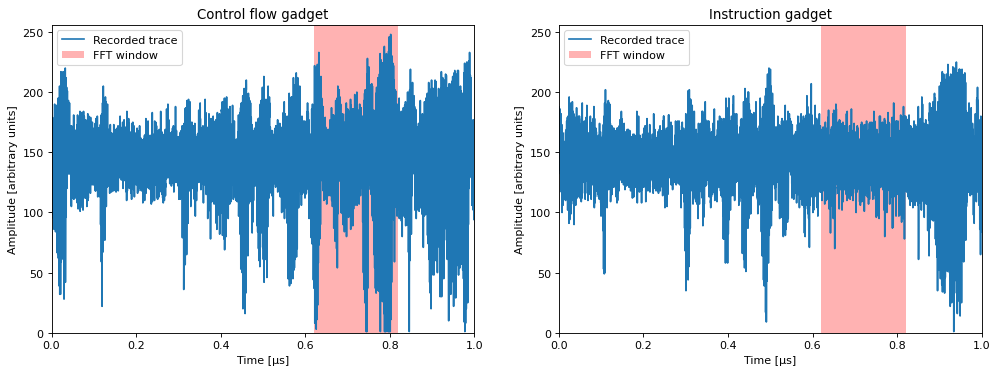

In [122]:
plt.figure(figsize=(15, 5), dpi=80)

ax = plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, 1, 25000, endpoint=False), traces_cf[0], label="Recorded trace")
rect = plt.Rectangle((f_cf.attrs["optimal_window_start"]/25000, 0), 0.2, 256, facecolor='r', alpha=0.3, label="FFT window")
ax.add_patch(rect)

plt.xlim(0, 1)
plt.ylim(0, 256)

plt.title("Control flow gadget")
plt.ylabel("Amplitude [arbitrary units]")
plt.xlabel("Time [μs]")
plt.legend()

ax = plt.subplot(1, 2, 2)
plt.plot(np.linspace(0, 1, 25000, endpoint=False), traces_ins[0], label="Recorded trace")
rect = plt.Rectangle((f_ins.attrs["optimal_window_start"]/25000, 0), 0.2, 256, facecolor='r', alpha=0.3, label="FFT window")
ax.add_patch(rect)

plt.xlim(0, 1)
plt.ylim(0, 256)

plt.title("Instruction gadget")
plt.ylabel("Amplitude [arbitrary units]")
plt.xlabel("Time [μs]")
plt.legend()

plt.show()

When plotting the frequency, a distinct peak can be observed at the clock frequency (600 MHz). We will use this frequency representation of the recorded trace to infer the encoded bit.

[]

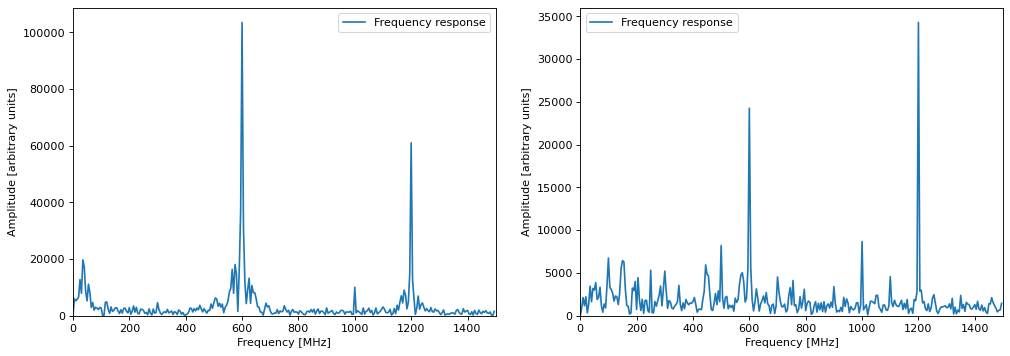

In [125]:
plt.figure(figsize=(15, 5), dpi=80)

ax = plt.subplot(1, 2, 1)
trace_fft = np.abs(fft(traces_cf[0, f_cf.attrs["optimal_window_start"]:f_cf.attrs["optimal_window_start"]+5000]))
trace_fft[0] = 0  # Component is too large otherwise

plot_fft_max = 1500 # MHz
plt.plot(np.linspace(0, plot_fft_max, plot_fft_max//5, endpoint=False), trace_fft[:plot_fft_max//5], label="Frequency response")

plt.xlim(0, plot_fft_max)
plt.ylim(0, None)

plt.title("Control flow gadget")
plt.ylabel("Amplitude [arbitrary units]")
plt.xlabel("Frequency [MHz]")
plt.legend()

ax = plt.subplot(1, 2, 2)
trace_fft = np.abs(fft(traces_ins[0, f_ins.attrs["optimal_window_start"]:f_ins.attrs["optimal_window_start"]+5000]))
trace_fft[0] = 0  # Component is too large otherwise

plot_fft_max = 1500 # MHz
plt.plot(np.linspace(0, plot_fft_max, plot_fft_max//5, endpoint=False), trace_fft[:plot_fft_max//5], label="Frequency response")

plt.xlim(0, plot_fft_max)
plt.ylim(0, None)

plt.title("Instruction gadget")
plt.ylabel("Amplitude [arbitrary units]")
plt.xlabel("Frequency [MHz]")
plt.legend()

plt.plot()

In order to evaluate the bit error rate (BER), we need to have access to a ground truth. To accommodate this, each batch records, besides the traces, also the inputs that were supplied to the gadget. These inputs refer to the bit index into the binary string that was placed in an architecturally inaccessible memory region. This 128-bit string was generated randomly, with the only constraint to contain as many zeros as ones as to not intoduce any bias.

Each trace encodes a single bit within this string. The index into this string is chosen randomly for each trace.

The function `get_bit` computes the ground truth for a given input value.

In [5]:
# The random string used in the POC SpectrEM implementations
data = b"data|\x01\x36\x9b\x78\xc9\x2c\x3d\x32\xfa\x83\x50\xaf\x39\xaf\x69\x2d\x58\xd7\x38\x6a\xc1\x63\x15\xc7\x3c\x4d\x96\x61\xe1\x88\xbd\xed"
data = np.frombuffer(data, dtype=np.uint8)

def get_bit(index):
    """Get the bit corresponding to the given inputs
    
    @param index The index for which to get the corresponding bit"""
    return (data[index // 8] & (1 << (index % 8))).astype(bool)

The 128-bit string was placed right behind a 5-byte (i.e., 40-bit) array (containing `data|`). As a result, all provided inputs are offset by 40 bits.

The histogram below shows the inputs for this specific batch. Note that we only keep the traces corresponding to the out-of-bound accesses.

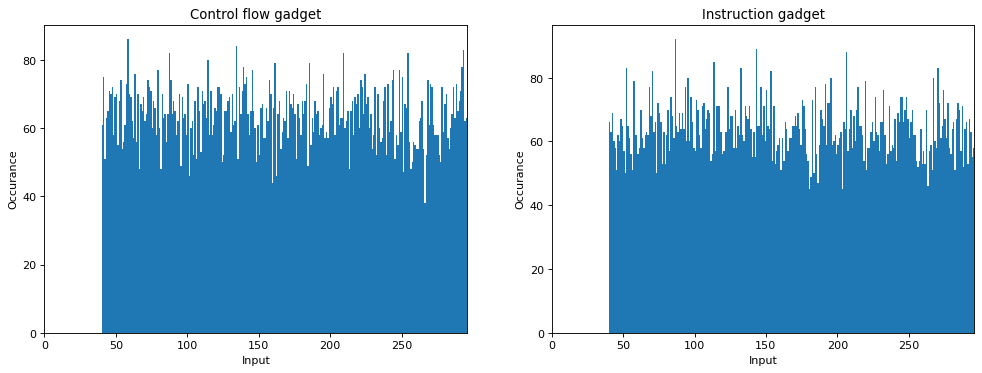

In [129]:
plt.figure(figsize=(15, 5), dpi=80)

ax = plt.subplot(1, 2, 1)
plt.hist(inputs_cf, bins=np.arange(0, len(data)*8+1));

plt.xlim(0, len(data)*8)
plt.ylim(0, None)

plt.title("Control flow gadget")
plt.ylabel("Occurance")
plt.xlabel("Input")

ax = plt.subplot(1, 2, 2)
plt.hist(inputs_ins, bins=np.arange(0, len(data)*8+1));

plt.xlim(0, len(data)*8)
plt.ylim(0, None)

plt.title("Instruction gadget")
plt.ylabel("Occurance")
plt.xlabel("Input")

plt.show()

When performing a *t*-test between the two bit values, the components that exhibit the most leakage can be identified. Note that these are different for both gadgets and correspond to the frequencies identified in Section 3.

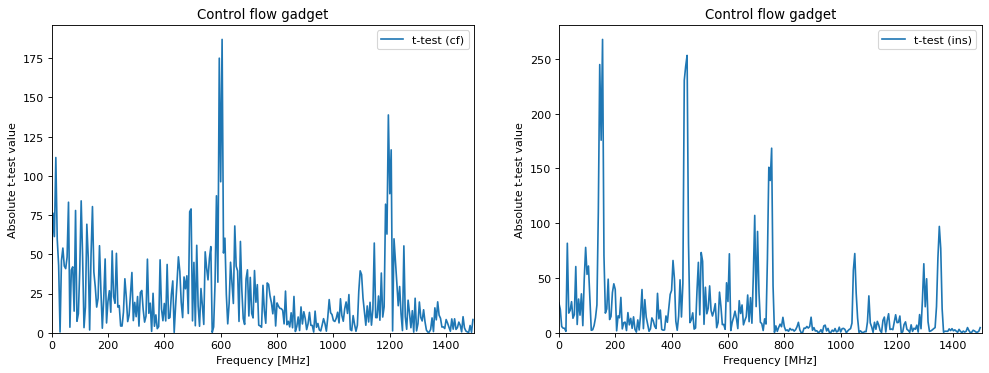

In [133]:
ind_1 = np.where(get_bit(inputs_cf[:]))[0]
ind_0 = np.setdiff1d(np.arange(16384), ind_1)

window_start = f_cf.attrs["optimal_window_start"]

traces_window = traces_cf[:, window_start:window_start+5000]
f = np.abs(fft(traces_window))[:,:1000]

t_cf, _ = sp.stats.ttest_ind(f[ind_0], f[ind_1], equal_var=False)

ind_1 = np.where(get_bit(inputs_ins[:]))[0]
ind_0 = np.setdiff1d(np.arange(16384), ind_1)

window_start = f_ins.attrs["optimal_window_start"]

traces_window = traces_ins[:, window_start:window_start+5000]
f = np.abs(fft(traces_window))[:,:1000]

t_ins, _ = sp.stats.ttest_ind(f[ind_0], f[ind_1], equal_var=False)

del f

plt.figure(figsize=(15, 5), dpi=80)

ax = plt.subplot(1, 2, 1)
plot_fft_max = 1500 # MHz
plt.plot(np.linspace(0, plot_fft_max, plot_fft_max//5, endpoint=False), np.abs(t_cf[:plot_fft_max//5]), label="t-test (cf)")

plt.xlim(0, plot_fft_max)
plt.ylim(0, None)

plt.title("Control flow gadget")
plt.ylabel("Absolute t-test value")
plt.xlabel("Frequency [MHz]")
plt.legend()

ax = plt.subplot(1, 2, 2)
plot_fft_max = 1500 # MHz
plt.plot(np.linspace(0, plot_fft_max, plot_fft_max//5, endpoint=False), np.abs(t_ins[:plot_fft_max//5]), label="t-test (ins)")

plt.xlim(0, plot_fft_max)
plt.ylim(0, None)

plt.title("Control flow gadget")
plt.ylabel("Absolute t-test value")
plt.xlabel("Frequency [MHz]")
plt.legend()

plt.show()

In [134]:
f_cf.close()
f_ins.close()

## Evaluation

This example will go through evaluating one batch of traces.

In [17]:
# Some helper functions

# The random string used in the POC SpectrEM implementations
data = b"data|\x01\x36\x9b\x78\xc9\x2c\x3d\x32\xfa\x83\x50\xaf\x39\xaf\x69\x2d\x58\xd7\x38\x6a\xc1\x63\x15\xc7\x3c\x4d\x96\x61\xe1\x88\xbd\xed"
data = np.frombuffer(data, dtype=np.uint8)

def get_bit_sp(index):
    """Get the bit corresponding to the given inputs
    
    @param index The index for which to get the corresponding bit"""
    return (data[index // 8] & (1 << (index % 8))).astype(bool)

def get_bit_md(inputs):
    """Get the bit corresponding to the given inputs for MeltEMdown
    
    @param inputs The inputs for which to retrieve the secret bit"""
    return inputs[:,2]

def is_cf(f_eval):
    """Determines whether the POC is using a control flow gadget"""
    return f_eval.attrs["gadget"] == "cf"

def filter_outliers(components, outlier_threshold: float=1.7):
    """Filters the outliers for the given components"""
    return np.where(abs(components - np.mean(components)) <= outlier_threshold * np.std(components))[0]

def get_optimal_window(f_eval):
    """Gets the optimal window position"""
    window_start = f_eval.attrs["optimal_window_start"]
    return slice(window_start, window_start + 5000)

We first precompute the frequency components for the given trace. These components are computed by taking an FFT over the optimal window.

Note that in this example, the window position is a parameter that can be tuned. We determined the optimal position using the MLP training data and saved it along with the traces for convenience. To observe the effect of using different window locations and how to optimize it, see [Optimizing Window Location](#window_opt).

In [12]:
filename = f"{prerecorded_traces_dir}/0-base-experiments/spectrem/cf/setup-b/spectrem_cf_0000.hdf5"

# These components represent the leaking frequency components for both types of gadgets.
# For the control flow gadget, the leakage is centered around the clock frequency component.
# For the instruction gadget, these components are located at the different frequency responses
# resulting from the udiv instructions.
# See also the example above where we compute the t-test scores for both gadgets.
IND_CF = np.array([119, 120, 121])
IND_INS = np.array([19, 20, 27, 28, 29, 30, 31, 32, 33, 89, 90, 91, 100, 140, 150, 210, 260, 270])

with h5py.File(filename, "r", libver="latest") as f_eval:
    traces = f_eval["data"]["traces"]
    inputs = f_eval["data"]["inputs"]

    print(f"File contains {traces.shape[0]} traces of length {traces.shape[1]} samples")

    window = get_optimal_window(f_eval)

    f = np.abs(fft(traces[:, window]))[:,:1000]

    # Note: When considering MeltEMdown, change this method to get_bit_md
    b = get_bit_sp(inputs[:])

    ind = IND_CF if is_cf(f_eval) else IND_INS

File contains 16384 traces of length 25000 samples


### MLP evaluation

We now evaluate the loaded batch of traced using the pre-trained MLP model.

In [13]:
pretrained_mlp = f"{prerecorded_traces_dir}/0-base-experiments/pretrained-mlp-models/spectrem/cf/setup-b/spectrem_cf_b_pretrained_model.hdf5"

# We first load in the saved model and predict the encoded bits.
model = tf.keras.models.load_model(pretrained_mlp, compile=False)
mlp_labels = np.squeeze(model.predict(f, verbose=0))

# To improve the BER, we only consider traces where the MLP network produced
# confident predictions. Each label for a trace returns two numbers that can
# be interpreted of the probability of that trace encoding that particular
# bit. We only consider traces for which the MLP network assigns a
# probability larger than 95%.
mlp_predictions = np.argmax(mlp_labels, axis=1)
mlp_confidence = np.max(mlp_labels, axis=1)
mlp_considered = np.where(mlp_confidence > 0.95)[0]
mlp_predictions = mlp_predictions[mlp_considered]

total_mlp = len(mlp_considered)
error_mlp = np.sum(mlp_predictions != b[mlp_considered])

print(f"MLP: {error_mlp/total_mlp:%} BER ({error_mlp} errors in {total_mlp} traces)")

MLP: 0.673486% BER (106 errors in 15739 traces)


### GMM evaluation

We now fit the recoded components using the GMM clustering algorithms.
We only consider traces that are not considered outliers and throw away all other traces.
While this reduces the raw throughput, the reduced error rate impoves the effective throughput.

In [14]:
# Filter traces for which the clock component is an outlier
# This is needed for the clustering algorithm as otherwise, the GMM
# algorithm may decide to consider the outliers as one of the two groups. 
ind_nol = filter_outliers(f[:,120])

# Filter only the frequency components that we will consider for the traces
# that we will consider. We do not supply all frequency components to the
# clustering algorithm as only few components exhibit leakage.
f_gmm = f[ind_nol[:,None],ind]

# Perform the actual clustering. 
gmm = GaussianMixture(n_components=2, covariance_type="full")
gmm_labels = gmm.fit_predict(f_gmm)

total_gmm = len(gmm_labels)
error_gmm = np.sum(gmm_labels == b[ind_nol])

# The GMM algorithm has no way to know which group represents a zero and
# which a one. As a result, we switch the groups should the GMM predict
# the bits the other way around.
if error_gmm > total_gmm//2:
    error_gmm = total_gmm-error_gmm

print(f"GMM: {error_gmm/total_gmm:%} BER ({error_gmm} errors in {total_gmm} traces)")

GMM: 1.604630% BER (244 errors in 15206 traces)


<a id='window_opt'></a>
## Influence of window position

In this section, we evaluate how the position of the FFT window influences the BER. Note that this is only done using the GMM method, as the MLP method is trained for one specific window location.

By optimizing the window location on the training data, the BERs can be minimized. This is because subsequent traces, taken on the same setup for the same gadget, will most likely have the same optimal window.

In [21]:
def evaluate_file_gmm(filename: str, get_bit, window: slice):
    """Evaluate the BER for the given batch of traces using both GMM and MLP evaluation.

    @param filename The filename of the batch containing the traces.
    @param mlp The filename of the pre-trained MLP model.
    @param get_bit A function that maps the inputs of the batches to their expected values.
    @param window The FFT window to consider
    """
    with h5py.File(filename, "r", libver="latest") as f_eval:
        traces = f_eval["data"]["traces"]
        inputs = f_eval["data"]["inputs"]

        f = np.abs(fft(traces[:, window]))[:,:1000]

        b = get_bit(inputs[:])

        ind = IND_CF if is_cf(f_eval) else IND_INS

    ############################## GMM Evaluation ##############################

    # Filter traces for which the clock component is an outlier
    # This is needed for the clustering algorithm as otherwise, the GMM
    # algorithm may decide to consider the outliers as one of the two groups. 
    ind_nol = filter_outliers(f[:,120])

    # Filter only the frequency components that we will consider for the traces
    # that we will consider. We do not supply all frequency components to the
    # clustering algorithm as only few components exhibit leakage.
    f = f[ind_nol[:,None],ind]

    # Perform the actual clustering. 
    gmm = GaussianMixture(n_components=2, covariance_type="full")
    gmm_labels = gmm.fit_predict(f)
    
    total_gmm = len(gmm_labels)
    error_gmm = np.sum(gmm_labels == b[ind_nol])

    # The GMM algorithm has no way to know which group represents a zero and
    # which a one. As a result, we switch the groups should the GMM predict
    # the bits the other way around.
    if error_gmm > total_gmm//2:
        error_gmm = total_gmm-error_gmm

        
    return error_gmm, total_gmm

In [23]:
filename = f"{prerecorded_traces_dir}/0-base-experiments/spectrem/cf/setup-b/spectrem_cf_0000.hdf5"

results = []

for window in tqdm(range(0, 20100, 500)):
    error, total = evaluate_file_gmm(filename, get_bit_sp, slice(window, window+5000))
        
    results.append((error, total))

results = np.array(results)

  0%|          | 0/41 [00:00<?, ?it/s]

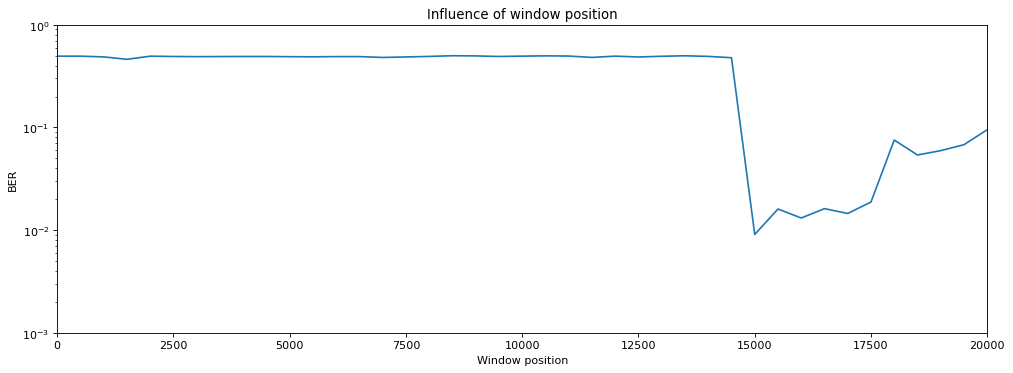

In [24]:
plt.figure(figsize=(15, 5), dpi=80)

plt.semilogy(np.arange(0, 20100, 500), results[:, 0] / results[:, 1])

plt.xlim(0, 20000)
plt.ylim(1e-3, 1)

plt.title("Influence of window position")
plt.ylabel("BER")
plt.xlabel("Window position")

plt.show()